# Notebook for RL agent in trading

In [54]:
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime
import yfinance as yf
import quandl
import torch
yf.pdr_override() 

## Yahoo API

In [55]:
# Replace 'AAPL' with the stock symbol you're interested in
stock_symbol = 'SPY'

### Define the pêriod

In [56]:
# Define the time period for historical data
start_date = datetime(2015, 1, 1)
end_date = datetime(2022, 1, 1)

### Get data from web

In [57]:
data = pdr.get_data_yahoo(stock_symbol, start=start_date, end=end_date)
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,206.380005,206.880005,204.179993,205.429993,174.806778,121465900
2015-01-05,204.169998,204.369995,201.350006,201.720001,171.649811,169632600
2015-01-06,202.089996,202.720001,198.860001,199.820007,170.033112,209151400
2015-01-07,201.419998,202.720001,200.880005,202.309998,172.151855,125346700
2015-01-08,204.009995,206.160004,203.990005,205.899994,175.206711,147217800


### Save to CSV

In [58]:
data.to_csv('SPY.csv')

### Get downloaded data

In [59]:
data = pd.read_csv('SPY.csv')
WINDOW_SIZE = 30  
data['moving_average'] = data['Close'].rolling(window=WINDOW_SIZE).mean()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,moving_average
0,2015-01-02,206.380005,206.880005,204.179993,205.429993,174.806778,121465900,NaN
1,2015-01-05,204.169998,204.369995,201.350006,201.720001,171.649811,169632600,NaN
2,2015-01-06,202.089996,202.720001,198.860001,199.820007,170.033112,209151400,NaN
3,2015-01-07,201.419998,202.720001,200.880005,202.309998,172.151855,125346700,NaN
4,2015-01-08,204.009995,206.160004,203.990005,205.899994,175.206711,147217800,NaN


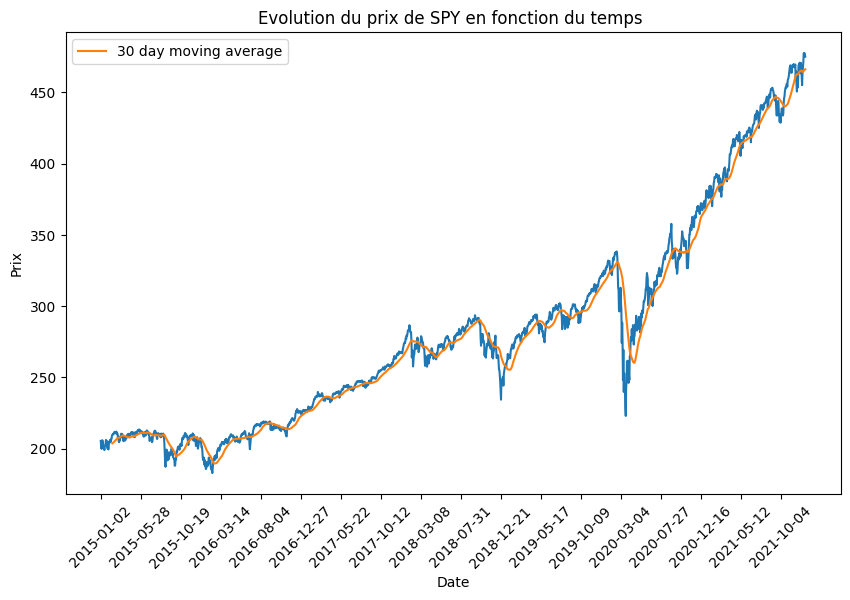

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data["Date"].to_numpy(), data['Close'].to_numpy(), linestyle='-')
plt.plot(data['moving_average'], label=f'{WINDOW_SIZE} day moving average')

plt.xlabel("Date")
plt.ylabel("Prix")

# do not plot all xticks
plt.xticks(data["Date"][::100], rotation=45)
plt.legend()
plt.title(f"Evolution du prix de {stock_symbol} en fonction du temps ")
plt.show()


## Implement DQNetwork

### Parameters

In [61]:
from utils.agent import Agent
from utils.env import SimplifiedStockTradingEnv
from utils.dqn import DQN
from utils.replay_buffer import ReplayBuffer
from utils.epsilon_greedy import EpsilonGreedy
from utils.lr_scheduler import MinimumExponentialLR

# Parameters
T = 20
price_list_size = T+1
sync_period=30
lr = 0.001
rb = 2000
es = 0.82
em = 0.013
ed = 0.9675
num_episodes=100
gamma=0.9
batch_size=128
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device


'mps'

In [62]:
# initializing a model and a target model
print("Creating Models ...")
model = DQN(price_list_size, 1, 1, device).to(device)
target_model = DQN(price_list_size, 1, 1, device).to(device)
print("... Models Created\n")

# initializing the optimizer, lr_scheduler and loss function
print("Creating Optimizer, LR Scheduler and Loss Function ...")
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, amsgrad=True)
            # lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
loss_fn = torch.nn.MSELoss()
print("... Optimizer, LR Scheduler and Loss Function Created\n")

# initializing the replay buffer
print("Creating Replay Buffer ...")
replay_buffer = ReplayBuffer(rb)
print("... Replay Buffer Created\n")

# initializing the environment
print("Creating Environment ...")
env = SimplifiedStockTradingEnv(data, T=T)
print("... Environment Created\n")

# initializing the epsilon greedy strategy
print("Creating Epsilon Greedy Strategy ...")
epsilon_greedy = EpsilonGreedy(epsilon_start=es, epsilon_min=em, epsilon_decay=ed, env=env, model=model)
print("... Epsilon Greedy Strategy Created\n")

# initializing the agent
print("Creating Agent ...")
agent = Agent(env, model, target_model, sync_period, optimizer, lr_scheduler, loss_fn, replay_buffer, epsilon_greedy)
print("... agent Created\n")


Creating Models ...
... Models Created

Creating Optimizer, LR Scheduler and Loss Function ...
... Optimizer, LR Scheduler and Loss Function Created

Creating Replay Buffer ...
... Replay Buffer Created

Creating Environment ...
... Environment Created

Creating Epsilon Greedy Strategy ...
... Epsilon Greedy Strategy Created

Creating Agent ...
... agent Created



### Training Agent

In [63]:
episode_reward_list = agent.train(num_episodes, gamma, batch_size)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.plot(episode_reward_list, label="Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

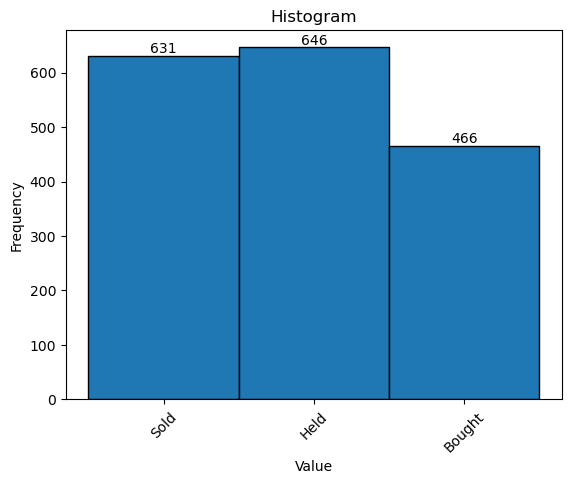

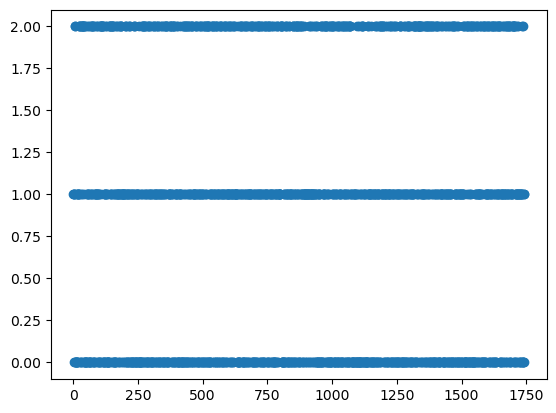

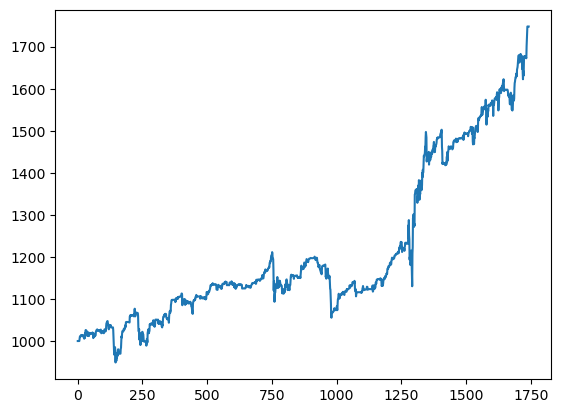

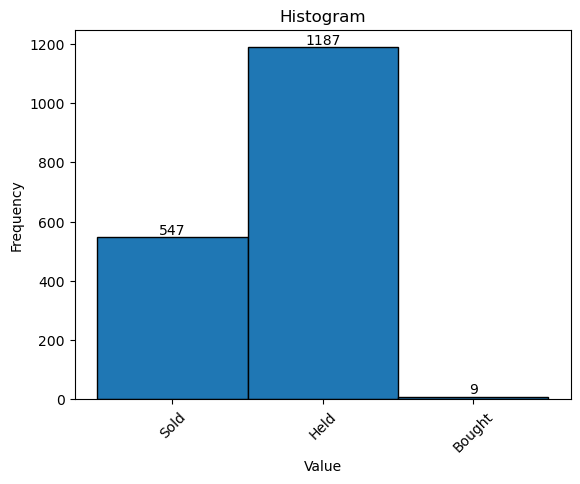

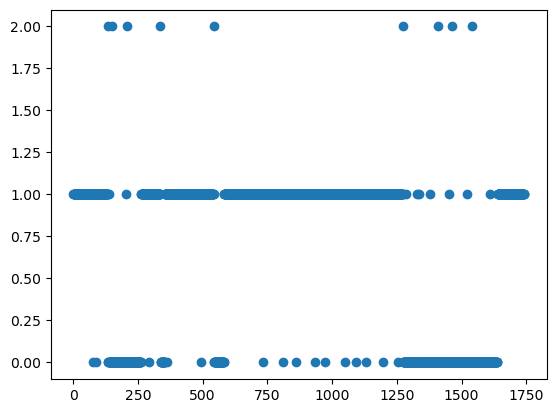

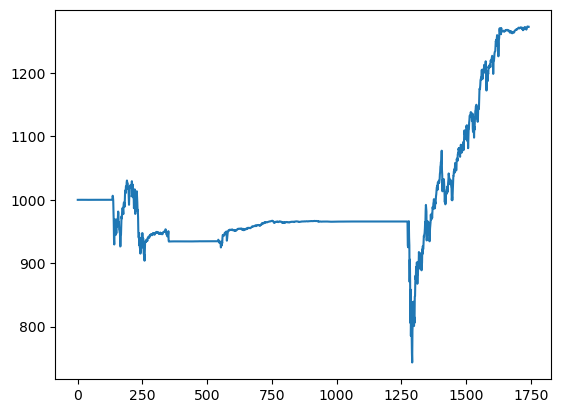

In [ ]:
import numpy as np

num_bins = 3
bin_edges = np.linspace(min(agent.action_list[0]), max(agent.action_list[0]), num_bins + 1)
hist, _ = np.histogram(agent.action_list[0], bins=bin_edges)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.bar(bin_centers, hist, width=np.diff(bin_edges), align='center', edgecolor='black')
plt.xticks(bin_centers, ['Sold', 'Held', 'Bought'], rotation=45)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
for i in range(len(hist)):
    plt.text(bin_centers[i], hist[i], str(int(hist[i])), ha='center', va='bottom')
plt.show()
plt.scatter(range(len(agent.action_list[0])), agent.action_list[0])
plt.show()
plt.plot(agent.wealth_list[0])
plt.show()
bin_edges = np.linspace(min(agent.action_list[-1]), max(agent.action_list[-1]), num_bins + 1)
hist, _ = np.histogram(agent.action_list[-1], bins=bin_edges)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.bar(bin_centers, hist, width=np.diff(bin_edges), align='center', edgecolor='black')
plt.xticks(bin_centers, ['Sold', 'Held', 'Bought'], rotation=45)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
for i in range(len(hist)):
    plt.text(bin_centers[i], hist[i], str(int(hist[i])), ha='center', va='bottom')
plt.show()
plt.scatter(range(len(agent.action_list[-1])), agent.action_list[-1])
plt.show()
plt.plot(agent.wealth_list[-1])
plt.show()